In [8]:
import torch
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.data import Dataset
from torch.utils.data import TensorDataset, DataLoader

## Data Handling

In [ ]:
data = pd.read_csv('dataset/twitter_training.csv')
data.columns = ['tweet_id', 'entity', 'sentiment', 'review']
print("Label Classes", data.sentiment.unique())
data.head()

Label Classes ['Positive' 'Neutral' 'Negative' 'Irrelevant']


,tweet_id,entity,sentiment,review
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
encoder = LabelEncoder()
data.drop(['tweet_id', 'entity'], inplace=True, axis=1)
data['sentiment_label'] = encoder.fit_transform(data['sentiment'])
print("Encoder Classes", encoder.classes_)
data.head()

Encoder Classes ['Irrelevant' 'Negative' 'Neutral' 'Positive']


,sentiment,review,sentiment_label
0,Positive,I am coming to the borders and I will kill you...,3
1,Positive,im getting on borderlands and i will kill you ...,3
2,Positive,im coming on borderlands and i will murder you...,3
3,Positive,im getting on borderlands 2 and i will murder ...,3
4,Positive,im getting into borderlands and i can murder y...,3


In [ ]:
print("NA Summary: \n------------------------\n" + str(data.isna().sum()))
data.dropna(inplace=True)
print("\nNA Summary: \n------------------------\n" + str(data.isna().sum()))

NA Summary: 
------------------------
sentiment            0
review             686
sentiment_label      0
dtype: int64

NA Summary: 
------------------------
sentiment          0
review             0
sentiment_label    0
dtype: int64


sentiment
Negative      22358
Positive      20654
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64


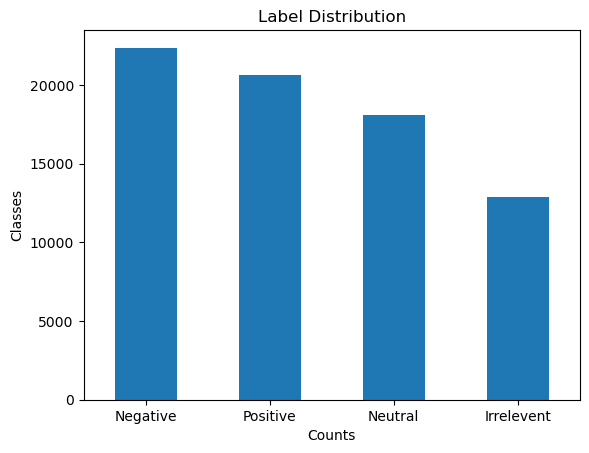

In [ ]:
val_counts = data['sentiment'].value_counts()
print(val_counts)

ax = val_counts.plot(kind='bar')
ax.set_xticklabels(['Negative', 'Positive' ,'Neutral', 'Irrelevent'], rotation=0)
plt.xlabel('Counts'); plt.ylabel('Classes'), plt.title('Label Distribution')
plt.show()

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

wnl = WordNetLemmatizer()
stop_words = stopwords.words('english')

def preprocess(text):
    words = nltk.word_tokenize(text.lower())
    filtered_words = [wnl.lemmatize(word) for word in words if word not in stop_words and len(word) >= 3]
    return " ".join(filtered_words)

example_text = 'Im getting on Borderlands and i will murder you'
print(f"Original: {example_text}\nProcessed: {preprocess(example_text)}")

Original: Im getting on Borderlands and i will murder you
Processed: getting borderland murder


In [ ]:
# print(data['review'].apply(type).value_counts())
data = data[data['review'].apply(lambda x: isinstance(x, str))]
print(data['review'].apply(type).value_counts())

data.review = data['review'].apply(preprocess)
data.head()

review
<class 'str'>    73995
Name: count, dtype: int64


,sentiment,review,sentiment_label
0,Positive,coming border kill,3
1,Positive,getting borderland kill,3
2,Positive,coming borderland murder,3
3,Positive,getting borderland murder,3
4,Positive,getting borderland murder,3


In [ ]:
data.to_csv('dataset/twitter_training_processed.csv')
from random import randint
x = randint(0, data.shape[0])
data.iloc[x:x+5, :]

,sentiment,review,sentiment_label
50676,Positive,great effort finlay lyttle aaron edward bring ...,3
50677,Positive,great effort finlay lyon aaron edward got nat5...,3
50678,Positive,great start finlay lyttle jacob edward getting...,3
50679,Positive,great effort aside finlay lyttle aaron edward ...,3
50680,Positive,great effort finlay lyttle aaron edward gettin...,3


## Modelling

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'cpu'

In [11]:
data = pd.read_csv('twitter_training_processed.csv')
data = data[data['review'].apply(lambda x: isinstance(x, str))]
print(data['review'].apply(type).value_counts())

review
<class 'str'>    72371
Name: count, dtype: int64


In [12]:
def get_vocab(reviews):
    vocab = {'__UNK__':0}
    for review in reviews:
        for word in review.split():
            if word not in vocab:
                vocab[word] = len(vocab)
    return vocab

vocab = get_vocab(data.review)
print(len(vocab))

37810


In [13]:
def tensor_len(text, unk_token='__UNK__'):
    tensor = []
    for word in text.split():
        if word not in vocab:
            word = unk_token
        tensor.append(vocab[word])
    return len(tensor)
max_tensor = len(max(data['review'], key=tensor_len))
print("Max Review(Input) size :", max_tensor)

def text_to_tensor(text, unk_token='__UNK__'):
    tensor = [0] * max_tensor
    for e, word in enumerate(text.split()):
        if word not in vocab:
            word = unk_token
        tensor[e] = vocab[word]
    return tensor

X = list(data['review'].apply(text_to_tensor))
y = list(data['sentiment_label'])

Max Review(Input) size : 814


## Pytorch Implementation

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = torch.as_tensor(X_train).to(device)
y_train = torch.as_tensor(y_train).to(device)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [9]:
X_test = torch.as_tensor(X_test).to(device)
y_test = torch.as_tensor(y_test).to(device)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [10]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("train_data length: ", len(train_data))

print("\nX_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("test_data length: ", len(test_data))

X_train shape: torch.Size([57896, 814])
y_train shape: torch.Size([57896])
train_data length:  57896

X_test shape: torch.Size([14475, 814])
y_test shape: torch.Size([14475])
test_data length:  14475


In [11]:
def torch_train(model, optimizer, criterion, epochs):
    model.to(device)
    train_loss=[]; train_accuracy=[]

    for epoch in range(epochs):
        model.train()
        total_correct=0;total_samples=0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        accuracy = total_correct/total_samples
        train_loss.append(loss.item())
        train_accuracy.append(accuracy*100)

        print(f"Epoch {epoch+1}/{epochs}:- Loss: {loss.item()}, Accuracy: {accuracy*100:.2f}")

In [12]:
def torch_test(model, criterion):
    total_correct=0; total_samples=0
    for inputs, labels in test_loader:
        outputs = model(inputs).to(device)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = total_correct/total_samples
    print(f"Loss: {loss.item()}, Accuracy: {accuracy*100:.2f}")

In [13]:
vocab_size = len(vocab) + 1
embed_size = 50
num_classes = data['sentiment'].nunique()

In [14]:
class FCtorch(torch.nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes):
        super(FCtorch, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_size)
        self.linear = torch.nn.Linear(embed_size, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        pooled = torch.mean(embedded, dim=1)
        output = self.linear(pooled)
        return output

In [15]:
model = FCtorch(vocab_size, embed_size, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

torch_train(model, optimizer, criterion, 10)

Epoch 1/10:- Loss: 0.9096807241439819, Accuracy: 40.71
Epoch 2/10:- Loss: 1.1223187446594238, Accuracy: 63.66
Epoch 3/10:- Loss: 0.46331140398979187, Accuracy: 73.60
Epoch 4/10:- Loss: 0.5243700742721558, Accuracy: 79.74
Epoch 5/10:- Loss: 0.040046326816082, Accuracy: 83.54
Epoch 6/10:- Loss: 0.15989607572555542, Accuracy: 85.72
Epoch 7/10:- Loss: 0.2364106923341751, Accuracy: 87.66
Epoch 8/10:- Loss: 0.10080787539482117, Accuracy: 88.54
Epoch 9/10:- Loss: 0.24252696335315704, Accuracy: 89.47
Epoch 10/10:- Loss: 0.7395386099815369, Accuracy: 90.04


In [16]:
torch_test(model, criterion)

Loss: 0.28555890917778015, Accuracy: 84.42


In [17]:
class RNNTorch(torch.nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes, hidden_size, num_layers, pretrain_emb_mat=None):
        super(RNNTorch, self).__init__()
        # self.embedding = torch.nn.Embedding.from_pretrained(pretrain_emb_mat, freeze=True)
        self.embedding = torch.nn.Embedding(vocab_size, embed_size)

        self.rnn = torch.nn.RNN(embed_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        # self.dropout = torch.nn.Dropout(p=0.1)

        self.linear = torch.nn.Sequential(
            torch.nn.Linear(hidden_size*2, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out,_ = self.rnn(embedded)
        # rnn_out = self.dropout(rnn_out)
        last_hidden = rnn_out[:,1]
        out = self.linear(last_hidden)
        return out

In [18]:
rnn_model = RNNTorch(vocab_size, embed_size, num_classes, 128, 3)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

torch_train(rnn_model, optimizer, criterion, 10)

Epoch 1/10:- Loss: 1.0208466053009033, Accuracy: 43.61
Epoch 2/10:- Loss: 0.7339982390403748, Accuracy: 58.10
Epoch 3/10:- Loss: 0.9047394394874573, Accuracy: 68.84
Epoch 4/10:- Loss: 1.3890459537506104, Accuracy: 73.44
Epoch 5/10:- Loss: 0.8136258125305176, Accuracy: 80.12
Epoch 6/10:- Loss: 0.3955254554748535, Accuracy: 84.32
Epoch 7/10:- Loss: 0.04416411370038986, Accuracy: 87.48
Epoch 8/10:- Loss: 0.14071328938007355, Accuracy: 89.18
Epoch 9/10:- Loss: 0.4298365116119385, Accuracy: 89.99
Epoch 10/10:- Loss: 1.1082686185836792, Accuracy: 91.91


In [19]:
torch_test(rnn_model, criterion)

Loss: 0.772495448589325, Accuracy: 80.37


In [33]:
class LSTMTorch(torch.nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes, hidden_size, num_layers):
        super(LSTMTorch, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_size)
        self.lstm = torch.nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(hidden_size*2, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out,_ = self.lstm(embedded)
        out = self.linear(lstm_out[:,1])
        return out

In [34]:
lstm_model = LSTMTorch(vocab_size, embed_size, num_classes, 128, 3)
optimizer = torch.optim.Adam(lstm_model.parameters())
criterion = torch.nn.CrossEntropyLoss()

torch_train(lstm_model, optimizer, criterion, 10)

Epoch 1/10:- Loss: 0.7666432857513428, Accuracy: 51.74
Epoch 2/10:- Loss: 0.553053617477417, Accuracy: 71.75
Epoch 3/10:- Loss: 0.38565436005592346, Accuracy: 84.73
Epoch 4/10:- Loss: 0.19708217680454254, Accuracy: 91.76
Epoch 5/10:- Loss: 0.01698257587850094, Accuracy: 94.80


KeyboardInterrupt: 

In [35]:
torch_test(lstm_model, criterion)

Loss: 0.8048198223114014, Accuracy: 85.20


## TensorFlow Implementation

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

train_data = Dataset.from_tensor_slices((X_train, y_train))
train_loader = train_data.shuffle(buffer_size=len(X_train)).batch(512)

In [15]:
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

test_data = Dataset.from_tensor_slices((X_test, y_test))
test_loader = test_data.batch(256)

In [16]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("train_data length: ", len(train_data))

print("\nX_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("test_data length: ", len(test_data))

X_train shape: (57896, 814)
y_train shape: (57896,)
train_data length:  57896

X_test shape: (14475, 814)
y_test shape: (14475,)
test_data length:  14475


In [17]:
def keras_train(model, optimizer, loss_fn, epochs):
    train_loss = []; train_accuracy = []

    for epoch in range(epochs):
        total_samples = 0; total_correct = 0
        epoch_loss=0

        for inputs, labels in train_loader:
            with tf.GradientTape() as tape:
                outputs = model(inputs, training=True)
                loss = loss_fn(labels, outputs)

            gradients = tape.grad(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            predictions = tf.argmax(outputs, axis=1)
            total_correct += tf.reduce_sum(tf.cast(predictions == labels, tf.float32)).numpy()
            total_samples += labels.shape[0]
            epoch_loss = loss.numpy()

        accuracy = total_correct / total_samples
        train_loss.append(epoch_loss)
        train_accuracy.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs}:- Loss: {epoch_loss / total_samples}, Accuracy: {accuracy * 100:.2f}")

In [18]:
def keras_test(model, loss_fn):
    total_correct=0; total_samples=0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        _, predicted = tf.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = total_correct/total_samples
    print(f"Loss: {loss.item()}, Accuracy: {accuracy*100:.2f}")

In [19]:
vocab_size = len(vocab) + 1
embed_size = 50
num_classes = data['sentiment'].nunique()

In [20]:
class FCKeras(keras.Model):
    def __init__(self, vocab_size, embed_size, num_classes):
        super(FCKeras, self).__init__()
        self.embedding = keras.layers.Embedding(vocab_size, embed_size)
        self.linear = keras.layers.Dense(num_classes)

    def call(self, x):
        embedded = self.embedding(x)
        pooled = tf.reduce_mean(embedded, axis=1)
        output = self.linear(pooled)
        return output

In [ ]:
model = FCKeras(vocab_size, embed_size, num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
criterion = tf.keras.losses.BinaryCrossentropy()

keras_train(model, optimizer, criterion, 10)

In [ ]:
class RNNKeras(keras.Model):
    def __init__(self, vocab_size, embed_size, num_classes, hidden_size, num_layers):
        super(RNNKeras, self).__init__()
        self.embedding = keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = keras.layers.SimpleRNN(hidden_size, return_sequences=False, return_state=False)
        self.fc = keras.layers.Dense(num_classes)

    def call(self, x):
        embedded = self.embedding(x)
        rnn_out = self.rnn(embedded)
        out = self.fc(rnn_out)
        return out

In [ ]:
X_train[0].shape

(57896, 814)

In [21]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Embedding, Dense, Bidirectional

hidden_size = 128

model = Sequential([
    Embedding(vocab_size, embed_size),
    Bidirectional(GRU(hidden_size)),
    Dense(num_classes*2, activation = 'relu'),
    Dense(num_classes, activation='softmax')
    ])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.fit(train_loader,
          validation_data=test_loader,
          epochs=5)

Epoch 1/5


 13/114 ━━━━━━━━━━━━━━━━━━━━ 9:17 6s/step - accuracy: 0.2784 - loss: 4.0771